### Librerias

In [5]:
!pip install astropy

In [6]:
!pip install gatspy

In [7]:
!pip install PyAstronomy

In [8]:
#Librerias necesarias:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from astropy.stats.lombscargle import LombScargle
from astropy.timeseries import LombScargle
from gatspy import datasets, periodic
from PyAstronomy.modelSuite import KeplerRVModel
from PyAstronomy import funcFit as fuf

%matplotlib inline

In [9]:
from scipy import optimize

### Velocidad Radial

In [10]:
df1 = pd.read_csv('Datos.txt',delim_whitespace=True, header=None)
#RF = df1.rename(columns={'=':'Tiempo [DJ]',
 #                             'T':'Flujo relativo'})
headers = ['JD', 'RV', 'RV_ERROR']

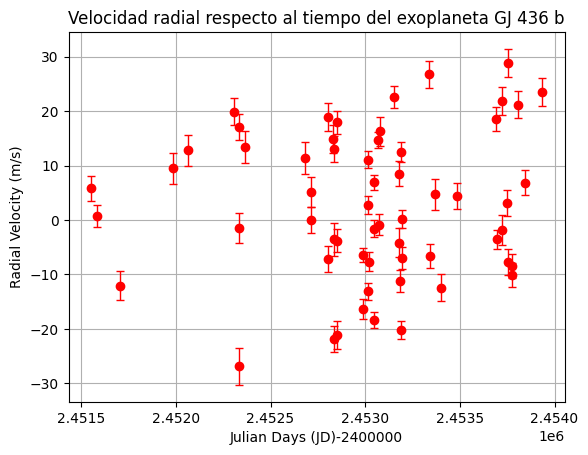

In [11]:
#Cargamos las series de tiempo:
df1 = pd.read_csv('Datos.txt',delim_whitespace=True, header=None)

#Nombramos cada una de las columnas:
headers = ['JD', 'RV', 'RV_ERROR']
df1.columns = headers

#Restamos 2400000 dias julianos por tema de orden
df1.JD= df1.JD

#En este caso, los datos ya vienen normalizados, por lo que 
# Dejamos comentada la normalización.
#df1['RV'] = (df1['RV'] - df1['RV'].mean())
#df1['RV_ERROR'] = df1['RV_ERROR'] - df1['RV_ERROR'].mean()


plt.errorbar(df1.JD, df1.RV, df1.RV_ERROR, fmt='or',capsize=3, elinewidth=1)
plt.xlabel('Julian Days (JD)-2400000')
plt.ylabel('Radial Velocity (m/s)')
plt.title('Velocidad radial respecto al tiempo del exoplaneta GJ 436 b', size=12)
plt.grid()
plt.show()

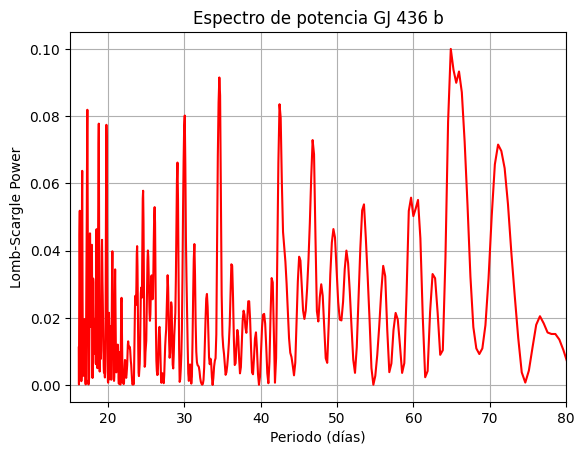

Finding optimal frequency:
 - Estimated peak width = 0.00264
 - Using 5 steps per peak; omega_step = 0.000528
 - User-specified period range:  1 to 1e+02
 - Computing periods at 11791 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
The orbital period for GJ 436 b is 2.644 days
El semieje mayor es 0.028 UA


In [12]:
#Aplicamos el Periodograma LombScargle a nuestros datos, para obtener el periodo:
freq, radV = LombScargle(df1.JD,df1.RV).autopower()

#Graficamos
plt.plot(1/freq, radV,'-r')
plt.xlabel("Periodo (días)")
plt.xlim(15,80)
plt.ylabel("Lomb-Scargle Power")
plt.title("Espectro de potencia GJ 436 b")
plt.grid()
plt.show()

# A partir de la serie de tiempo, damos un rango estimado donde podría estar el periodo:
model = periodic.LombScargle(fit_period=True)
model.optimizer.period_range = (1,100. )
model.fit(df1.JD, df1.RV,)

# A partir de la serie de tiempo, damos un rango estimado donde podría estar el periodo:
P=model.best_period
print("The orbital period for GJ 436 b is %.3f"% P, "days")

#Ponemos la masa de la estrella:
M = 0.4411671425335 # Masas solares
P1 = P/365.25 #Periodo en años

#Por la tercera ley de Kepler, calculamos el semieje mayor.
a = ((P1**2)*(M))**(1/3) # Semi eje mayor en unidades astronómicas
print ("El semieje mayor es %.3f"% a, "UA")

C:\Users\kathe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PyAstronomy\funcFit\onedfit.py:687: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  self._result = sco.fmin(miniFunc, x0, *fminpars,


(array([ 9.36965768e+00,  2.31717161e+00,  1.60048630e-07,  1.93174122e+06,
        3.44346598e+02, -6.87668916e-04]), 751.9325903558489)
chi-square and reduced chi-square: 751.933, 14.187
RMS:  7.867670553556723


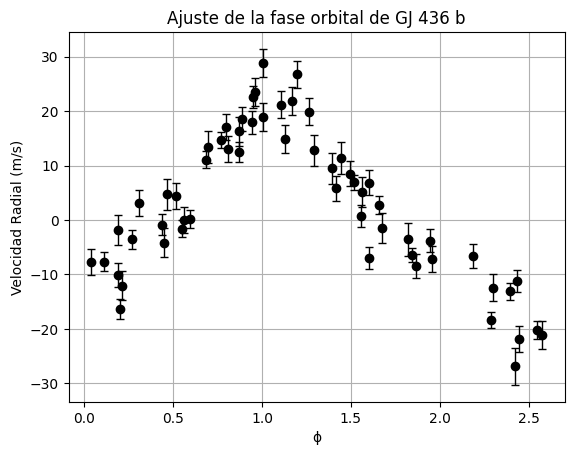

In [13]:
# Cargamos los datos que usaremos en el modelo.
jd = np.array((df1.JD)%P)
rv = np.array(df1.RV)
# Error
rverr = np.array(df1.RV_ERROR)

# Modelamos un sistema con 1 solo planeta con desplazamiento constante:
krvm = KeplerRVModel(mp=1, deg=0)

# Ponemos la masa de la estrella:
krvm["mstar"] = 0.441167142


# Damos algunos parámetros iniciales (initial guesses) para los elementos orbitales
krvm["per1"] = P
krvm["K1"] = 8
krvm["e1"] = 0
krvm["tau1"] = 2440000.5
krvm["w1"] =120.

# Ajustamos todos los parámetros menos el periodo
krvm.thaw(["K1", "w1", "e1","tau1","c0"])
# ... Ahora también el periodo
krvm.thaw(["per1"])
krvm.fit(jd, rv, yerr=rverr)
#Ahora, obtenemos el mejor modelo ajustado
kmo = krvm.evaluate(jd)

# Procedemos a calcular el chi cuadrado y el RMS
chi = np.sum( (rv - krvm.model)**2 / rverr**2 )
# RMS
rchi = chi / (len(rv) - len(krvm.freeParameters()))
print("chi-square and reduced chi-square: %6.3f, %6.3f" % (chi, rchi))
rms = np.std(rv - krvm.model)
print("RMS: ", rms)

# Tomamos los datos y los organizamos, para realizar el diagrama de fase.
l=np.c_[jd,krvm.model]
f=l[l[:,0].argsort()]

#Procedemos a graficar
plt.title("Ajuste de la fase orbital de GJ 436 b")
plt.xlabel("ϕ")
plt.ylabel("Velocidad Radial (m/s)")
#plt.plot(f[:,0]/P, f[:,1], 'r-')
plt.errorbar(jd, rv, yerr=rverr, fmt='ok',capsize=3, elinewidth=1)
plt.grid()
plt.show()

In [14]:
def sin(x,a,b,c):
    return a*np.sin(b*x +c)

G = 6.67e-11

omegainit = 120
init = [3, omegainit, 1]
popt, pcov = optimize.curve_fit(sin, jd/P, rv)

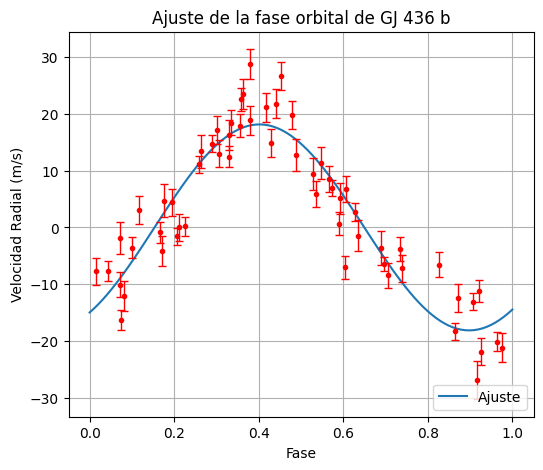

La semiamplitud es: 18.154852009047932+-1.1


In [15]:
#Procedemos a graficar
fig = plt.figure(figsize=(6,5))
#plt.plot(jd/P, rv,"+",label="Datos de 11 Com b")
x = np.linspace(0,1,100)
plt.plot(x, sin(x, *popt), label="Ajuste")
plt.errorbar(jd/P, rv, yerr=rverr, fmt='.r',capsize=3, elinewidth=1)
plt.legend(loc=4)
plt.title("Ajuste de la fase orbital de GJ 436 b")
plt.xlabel("Fase")
plt.ylabel("Velocidad Radial (m/s)")
plt.grid()
plt.show()

kk = sin(x, *popt)
kkerr = (np.max(rverr) - np.min(rverr))/2
print(f"La semiamplitud es: {(np.max(kk) - np.min(kk))/2}+-{kkerr}")

In [16]:
# Tomamos la ecuación de la masa mínima en unidades canónicas, obteniendo así:

mpsin =(((np.max(kk) - np.min(kk))/2)/(28.4329))*((0.4411671425335)**(2./3.))*((P/365.)**(1./3.))*(np.sqrt(1))
print("La masa mínima es: %.4f"%mpsin, "Mj")

La masa mínima es: 0.0716 Mj


In [17]:
-0.07/mpsin *100 + 100

2.2297912636819888

In [18]:
mpsin/np.sin(np.deg2rad(86.44))

0.07173487668502299

In [19]:
100 - 17.2/18.15*100

5.234159779614316

In [20]:
100 - 0.668/0.716 *100

6.703910614525128

### Transito


In [21]:
from scipy import interpolate

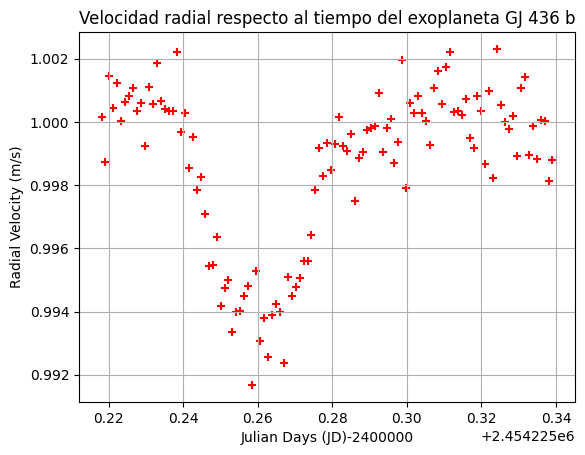

In [22]:
fr = pd.read_csv('Flujo.txt',delim_whitespace=True, header=None)
#RF = df1.rename(columns={'=':'Tiempo [DJ]',
 #                             'T':'Flujo relativo'})
headers = ['JD', 'FR', 'FR_ERROR']
fr.columns = headers

plt.scatter(fr.JD, fr.FR, marker='+', c='r')
plt.xlabel('Julian Days (JD)-2400000')
plt.ylabel('Radial Velocity (m/s)')
plt.title('Velocidad radial respecto al tiempo del exoplaneta GJ 436 b', size=12)
plt.grid()
plt.show()

In [38]:
from scipy.interpolate import interp1d


In [55]:
def ff(x, a, b, c, d):
    return a*x**2 + b*np.cos(c*x+d)
def fun(x, a,b,c):
    return a * np.sin(b* x) + c

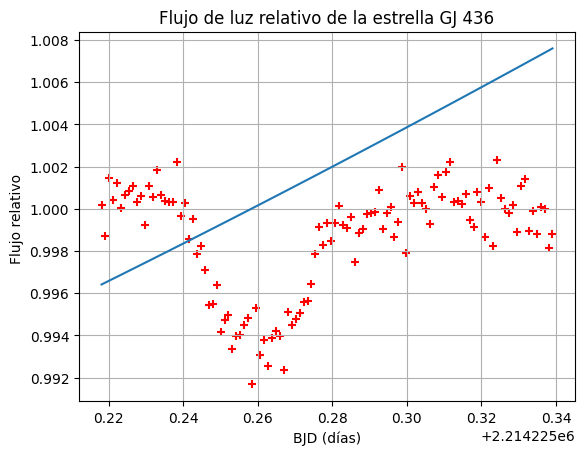

In [59]:
para = [1, 1, np.pi/2, 0]
a = interpolate.interp1d(fr.JD, fr.FR)

jd = np.array(fr.JD)-240000

params, params_covariance = optimize.curve_fit(fun, jd, fr.FR)

# Obtener los parámetros óptimos
params_opt = params

# Generar la curva ajustada
xx = np.linspace(jd[0], np.max(jd), 115)
y_fit = fun(xx, *params_opt)

plt.scatter(jd, fr.FR, marker='+', c='r')
plt.plot(xx, y_fit, '')
plt.xlabel('BJD (días)')
plt.ylabel('Flujo relativo ')
plt.title('Flujo de luz relativo de la estrella GJ 436', size=12)
plt.grid()
plt.show()

In [147]:
df = (0.9999-0.9943)/0.9999

In [148]:
res = 0.41684304009*696340*1000
rp = np.sqrt(df)*res
(rp)/(69911*1000)

0.3107163544464592

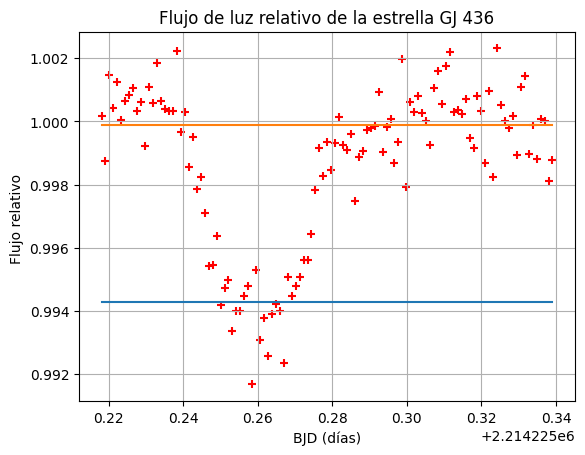

In [146]:
plt.scatter(jd, fr.FR, marker='+', c='r')
plt.plot(xx, np.ones(72)*0.9943, '')
plt.plot(xx, np.ones(72)*0.9999, '')
plt.xlabel('BJD (días)')
plt.ylabel('Flujo relativo ')
plt.title('Flujo de luz relativo de la estrella GJ 436', size=12)
plt.grid()
plt.show()

In [119]:
jdmax = np.concatenate((jd[:22], jd[65:]))
frmax = np.concatenate((fr.FR[:22],fr.FR[65:]))

def max(x, a,b):
    return a*x + b
params, params_covariance = optimize.curve_fit(max, jdmax, frmax)
xx = np.linspace(jd[0], np.max(jd), 72)
ymax = max(xx, *params)

def min(x, a,b):
    return a*x+b
para, params_covariance = optimize.curve_fit(min, fr.JD[30:50], fr.FR[30:50])
xxx = np.linspace(jd[0], np.max(jd), 72)
ymin = min(xxx, *para)


### Zona

In [149]:
def L1(M):
    return 0.23*M**2.3
def L2(M):
    return M**4
def R(M):
    return M#**0.75
Ms = np.linspace(0.1,1.2,100000)

Ls = np.array([])
for i in range(len(Ms)):
    if Ms[i] < 0.43:
        Ls = np.append(Ls,L1(Ms[i]))
    else:
        Ls= np.append(Ls,L2(Ms[i]))
Rs = R(Ms)

In [150]:
Ts = (Ls/(Rs**2))**0.25

In [ ]:
a(M) = -141.7M^4 + 232.4M^3 - 129.1M^2 + 33.29M + 0.215

In [ ]:
defxqes

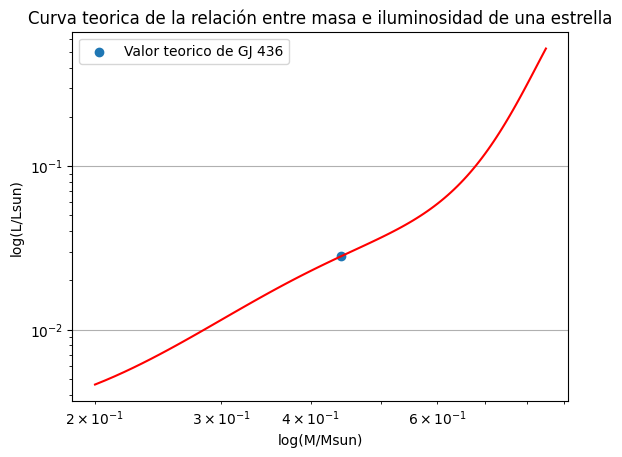

In [187]:
def Ilum(M):
    msun = 1
    a = -141.7*M**4 + 232.4*M**3 - 129.1*M**2 + 33.29*M + 0.215
    return (M/msun)**a
def MM(M):
    msun = 1
    return M/msun


M = np.linspace(0.2, 0.85, 100)
x = MM(M)
L = Ilum(M)

plt.plot(x, L, 'r')
plt.scatter(MM(0.441), Ilum(0.441), marker='o', label='Valor teorico de GJ 436')
#plt.scatter(MM(0.441), 1.63335, marker='o', c='m')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel('log(M/Msun)')
plt.ylabel('log(L/Lsun)')
plt.title('Curva teorica de la relación entre masa e iluminosidad de una estrella')
plt.legend()


In [ ]:

def Lgj(M):
    Lsun = 3.827e26
    M1 = M
    M = M*1.989e30
    a = -141.7*M**4 + 232.4*M**3 - 129.1*M**2 + 33.29*M + 0.215
    return ((M1)**a * Lsun)

In [215]:
def L1(M):
    return 0.23*M**2.3
def L2(M):
    return M**4

Ms = np.linspace(0.001,1.2,1000)
Ms.append(6.68212e-5)
Ls = np.array([])
for i in range(len(Ms)):
    if Ms[i] < 0.43:
        Ls = np.append(Ls,L1(Ms[i]))
    else:
        Ls= np.append(Ls,L2(Ms[i]))
rgj = 696340*1000*0.416843040098
Rs = np.ones(1000)*rgj
Rs.append(696340*1000*0.416843040098)

plt.plot(Ms, Ls, 'r')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel('log(M/Msun)')
plt.ylabel('log(L/Lsun)')
plt.title('Curva teorica de la relación entre masa e iluminosidad de una estrella')

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [216]:

Ts = (Ls/(Rs**2))**0.25

Tstar = Ts*5780 - 5780
#Recent venus

Sseff1  = 1.7763
a1 = 1.4335e-4
b1 = 3.3953e-9
c1 = -7.6364e-12
d1 = -1.1950e-15


Seff1 = Sseff1 + a1*Tstar + b1*Tstar**2 + c1*Tstar**3 + d1*Tstar**4

#Runaway greenhouse

Sseff2 = 1.0385
a2 = 1.2456e-4
b2 = 1.4612e-8
c2 = -7.6345e-12
d2 = -1.7511e-15

Seff2 = Sseff2 + a2*Tstar + b2*Tstar**2 + c2*Tstar**3 + d2*Tstar**4

#Moist greenhouse

Sseff3 = 1.0146
a3 = 8.1884e-5
b3 = 1.9394e-9
c3 = -4.3618e-12
d3 = -6.8260e-16

Seff3 = Sseff3 + a3*Tstar + b3*Tstar**2 + c3*Tstar**3 + d3*Tstar**4
#maximum greehouse

Sseff4 = 0.3507
a4 = 5.9578e-5
b4 = 1.6707e-9
c4 = -3.0058e-12
d4 = -5.1825e-16

Seff4 = Sseff4 + a4*Tstar + b4*Tstar**2 + c4*Tstar**3 + d4*Tstar**4

#early mars

Sseff5 = 0.3207
a5 = 5.4471e-5
b5 = 1.5275e-9
c5 = -2.1709e-12
d5 = -3.8282e-16

Seff5 = Sseff5 + a5*Tstar + b5*Tstar**2 + c5*Tstar**3 + d5*Tstar**4


d1  = (Ls/Seff1)**0.5
d2  = (Ls/Seff2)**0.5
d3  = (Ls/Seff3)**0.5
d4  = (Ls/Seff4)**0.5
d5  = (Ls/Seff5)**0.5

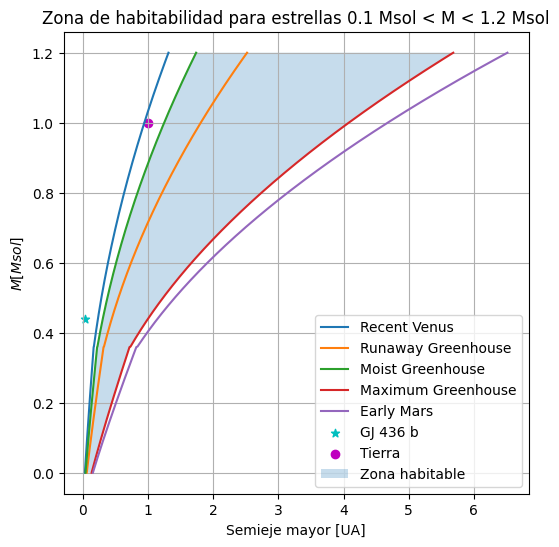

In [224]:
#fig = plt.figure(dpi=100)
fig = plt.figure(figsize=(6,6))
plt.plot(d1,Ms,label="Recent Venus")
plt.plot(d2,Ms,label="Runaway Greenhouse")
plt.plot(d3,Ms,label="Moist Greenhouse")
plt.plot(d4,Ms,label="Maximum Greenhouse")
plt.plot(d5,Ms,label="Early Mars")

"""
plt.scatter(d1[-1],Ms[-1],label="Recent Venus")
plt.scatter(d2[-1],Ms[-1],label="Runaway Greenhouse")
plt.scatter(d3[-1],Ms[-1],label="Moist Greenhouse")
plt.scatter(d4[-1],Ms[-1],label="Maximum Greenhouse")
plt.scatter(d5[-1],Ms[-1],label="Early Mars")
"""

plt.scatter(0.028 , 0.44116714, marker='*',c='c',label='GJ 436 b')
plt.scatter(1, 1, marker='o',c='m', label='Tierra')
plt.fill_betweenx(Ms,d3,d4,alpha = 0.25, label="Zona habitable")
plt.xlabel("Semieje mayor [UA]")
plt.ylabel("$M [Msol]$")
plt.title("Zona de habitabilidad para estrellas 0.1 Msol < M < 1.2 Msol")
plt.grid()
plt.legend()